## ラベル補正アルゴリズム検討
### ミスしたIDの数 (全ID数 (全てのサンプルをミスしたID数, 一部のサンプルをミスしたID数))
- dataset03: 63 (9, 54)
- dataset04: 79 (38, 41)
- dataset05: 42 (6, 38)

### 全てにミスが有る
補正できるパターンは見つからない
- dataset03:
  - 正解0, 予測1 (31, 53, 237, 429)
  - 正解0, 予測4 (702, 704)
  - 正解1, 予測0,2 (362, 671)
  - 正解4, 予測3  (200)
- dataset04:
  - 正解3, 予測0,1,2  (198, 207, 209, 224, 229, 236, 239, 240, 269, 272, 321, 323, 380, 428, 445, 483, 493, 515, 525, 560, 579, 697, 804)
  - 正解4, 予測0,3,2  (5, 8, 15, 22, 105, 165, 442, 534, 547, 710, 726, 733, 736, 742, 764)
- dataset05:
  - 正解0, 予測3 (9)
  - 正解3, 予測0 (164, 212, 252, 302)
  - 正解4, 予測0 (315)
### 一部にミスがある
- 最初にミスが有るパターンは無視 -> リアルタイムに対応できない
- ラベル信頼度の移動平均 -> 約1%精度上昇(05, 03), 約0.3%精度上昇(04)
そこまで補正できないため必要ない?

In [39]:
%cd /raid6/home/yokoyama/har-for-or/
import os
import sys
from glob import glob
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score

sys.path.append(".")
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


In [40]:
# test
model_type = "sqvae"
dataset_num = 5
if dataset_num == 3:
    v = 0
elif dataset_num == 4:
    v = 1
elif dataset_num == 5:
    v = 2
checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(
    f"{checkpoint_dir}/individual-{model_type}.yaml"
)
seq_len = config.seq_len
stride = config.stride

# load preds
data_root = f"../datasets/dataset{dataset_num:02d}/test/{video_num:02d}"
paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
results = []
for path in paths:
    with open(path, "rb") as f:
        results.append(pickle.load(f))

In [41]:
label_preds = []
label_gts = []
miss_ids = []
ann_keys = annotations.T[0]
for result in results:
    key = result["key"]
    video_num, n_frame, _id = key.split("_")
    n_frame = int(n_frame)
    key = f"{video_num}_{_id}"
    label_pred = result["label"]
    label_preds.append(label_pred)

    ann_tmp = annotations[ann_keys == key]
    if len(ann_tmp) >= 2:
        # groud truth is chenged sometimes since the tracking model mistakes
        ann_n_frames = ann_tmp.T[2].astype(int)
        ann_tmp = ann_tmp[ann_n_frames <= n_frame][-1]
        label_gt = int(ann_tmp[1])
    else:
        label_gt = int(ann_tmp[0, 1])
    label_gts.append(label_gt)

    if label_pred != label_gt and int(_id) not in miss_ids:
        miss_ids.append(int(_id))

miss_ids = np.array(miss_ids)

0.9453572793274742


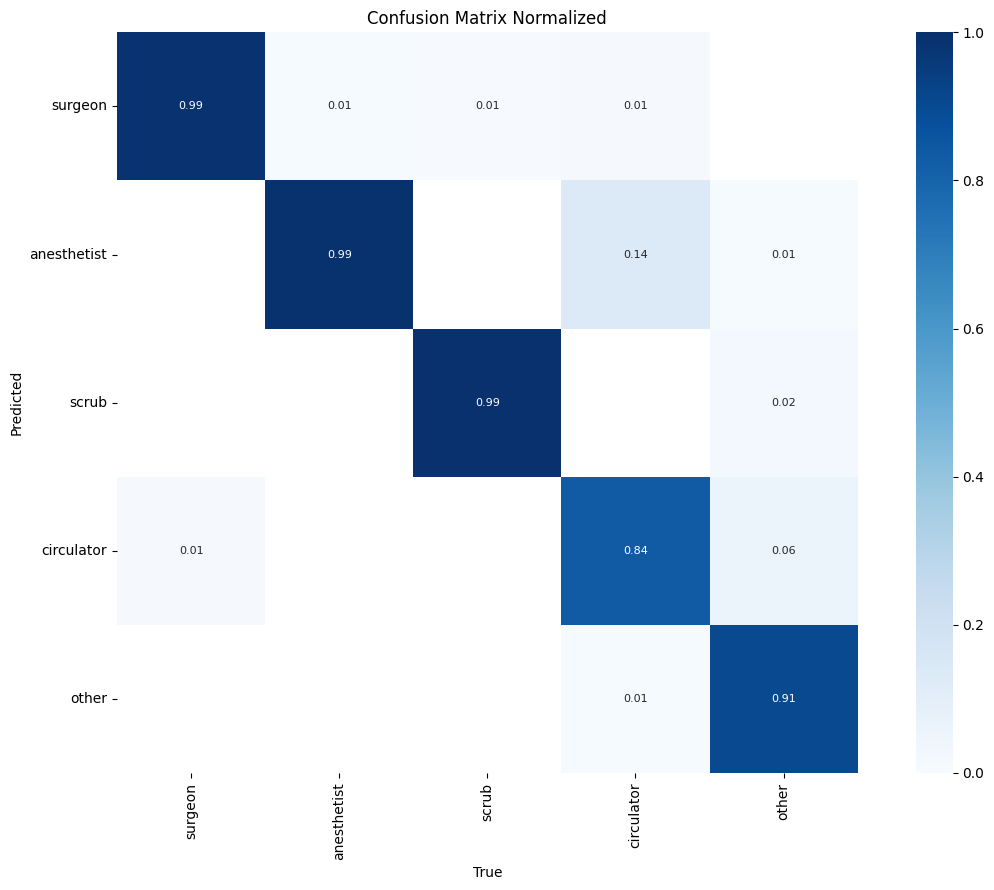

In [42]:
def plot_cm(cm, labels, save_path=None, normalize=False, on_plot=True):
    array = cm / (
        (cm.sum(0).reshape(1, -1) + 1e-9) if normalize else 1
    )  # normalize columns
    array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
    ticklabels = labels
    vmax = 1.0 if normalize else None
    sns.heatmap(
        array,
        ax=ax,
        annot=True,
        annot_kws={"size": 8},
        cmap="Blues",
        fmt=".2f" if normalize else ".0f",
        square=True,
        vmin=0.0,
        vmax=vmax,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    ).set_facecolor((1, 1, 1))

    title = "Confusion Matrix" + " Normalized" * normalize
    ax.set_xlabel("True")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("Predicted")
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(title)
    if save_path is not None:
        if normalize:
            save_path = save_path.replace(".png", "") + "_normalized.png"
        fig.savefig(save_path, dpi=250)
    if on_plot:
        plt.show()
    plt.close(fig)


print(accuracy_score(label_gts, label_preds))
cm = confusion_matrix(label_gts, label_preds).T
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
labels = np.loadtxt(path, str, usecols=0)
plot_cm(cm, labels, normalize=True)

In [43]:
len(miss_ids)

35

In [44]:
miss_samples = {}
for r, label_gt in zip(results, label_gts):
    video_num, n_frame, _id = r["key"].split("_")
    n_frame = int(n_frame)
    _id = int(_id)
    label_pred = r["label"]
    c0, c1, c2, c3, c4 = r["label_prob"]
    x1, y1, x2, y2 = r["bbox"][-1].reshape(-1)

    if _id in miss_ids and _id not in miss_samples:
        miss_samples[_id] = []

    if _id in miss_samples:
        miss_samples[_id].append(
            (n_frame, label_pred, label_gt, c0, c1, c2, c3, c4, x1, y1, x2, y2)
        )

In [45]:
# all labels are fail
miss_ids_all = []
for _id, sample in miss_samples.items():
    sample = np.array(sample)
    if np.all(sample.T[1] != sample.T[2]):
        miss_ids_all.append(_id)

miss_ids_all = np.array(miss_ids_all)
len(miss_ids_all)

5

In [46]:
miss_ids_part = miss_ids[~np.isin(miss_ids, miss_ids_all)]
len(miss_ids_part)

30

In [47]:
miss_ids_all

array([155, 299, 315, 467, 701])

In [48]:
# count = 0
# for _id in miss_ids_all:
#     sample = np.array(miss_samples[_id]).astype(int)
#     if np.all(sample.T[2] == 3):
#         print(_id)
#         print(sample.T[:3].T)
#     count += len(sample)
# print(count)

In [49]:
miss_ids_part

array([ 16,   1,  28,  47,  23,  78,  39,  73,  90,  31, 129, 162, 198, 217, 228, 336, 322, 302, 339, 255, 375, 351, 483, 442, 484, 549, 487, 617, 749, 752])

# 全てに間違いがあるデータ

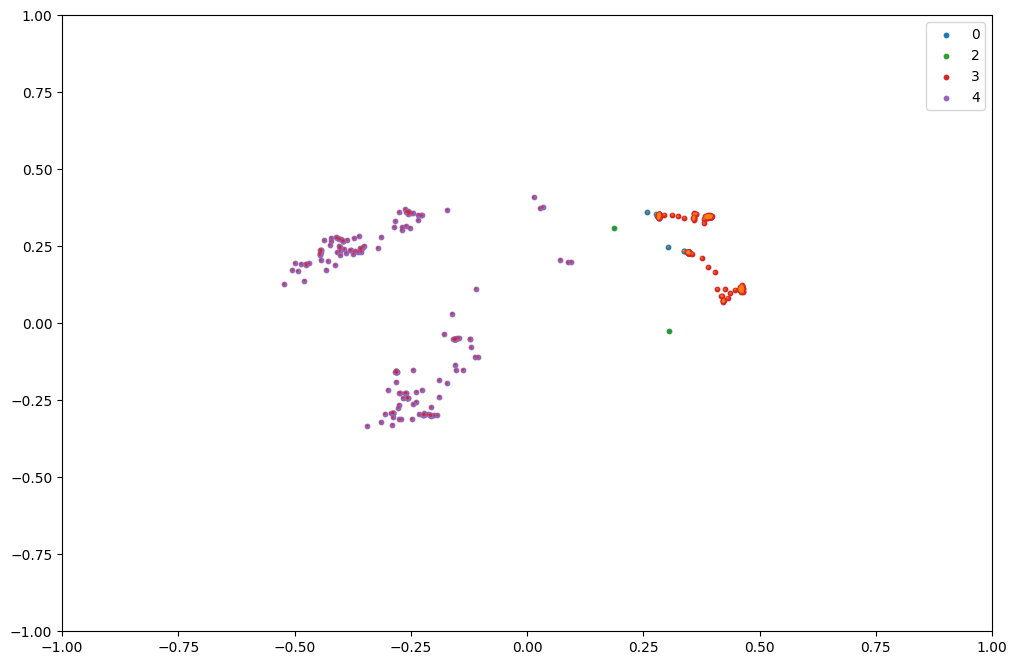

In [50]:
# scatter of bbox in all samples are fail
x1_all = []
y1_all = []
x2_all = []
y2_all = []
label_preds = []
label_gts = []
for _id in miss_ids_all:
    sample = miss_samples[_id]
    sample = np.array(sample)
    x1, y1, x2, y2 = sample.T[8:]
    x1_all += x1.tolist()
    y1_all += (y1 * -1).tolist()
    x2_all += x2.tolist()
    y2_all += (y2 * -1).tolist()
    label_preds += sample.T[1].tolist()
    label_gts += sample.T[2].tolist()
x1_all = np.array(x1_all)
y1_all = np.array(y1_all)
x2_all = np.array(x2_all)
y2_all = np.array(y2_all)
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)

cm = plt.get_cmap("tab10")
fig = plt.figure(figsize=(12, 8))
for label_gt in np.unique(label_gts):
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot gt
    c = cm(label_gt)
    plt.scatter(x1_all[mask], y1_all[mask], s=10, color=c, label=label_gt)
    plt.scatter(x2_all[mask], y2_all[mask], s=10, color=c)

    # plot pred
    c = [cm(p) for p in preds_tmp]
    plt.scatter(x1_all[mask], y1_all[mask], s=1, color=c, alpha=0.5)
    plt.scatter(x2_all[mask], y2_all[mask], s=1, color=c, alpha=0.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.show()

0


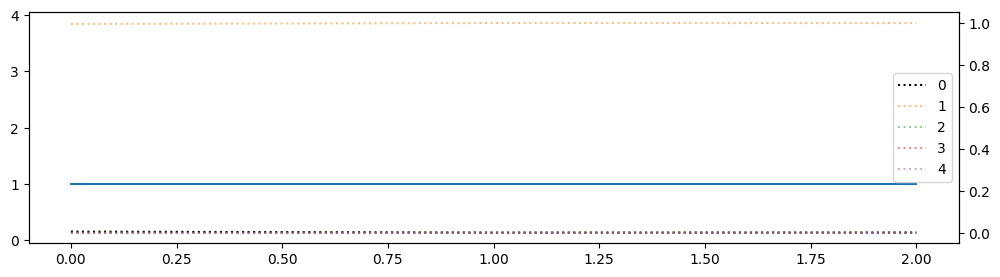

2


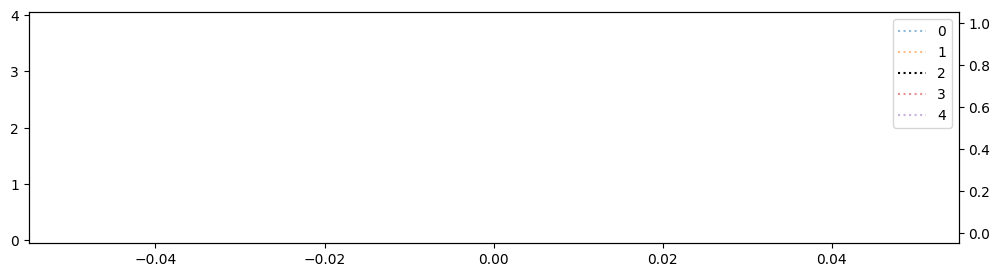

3


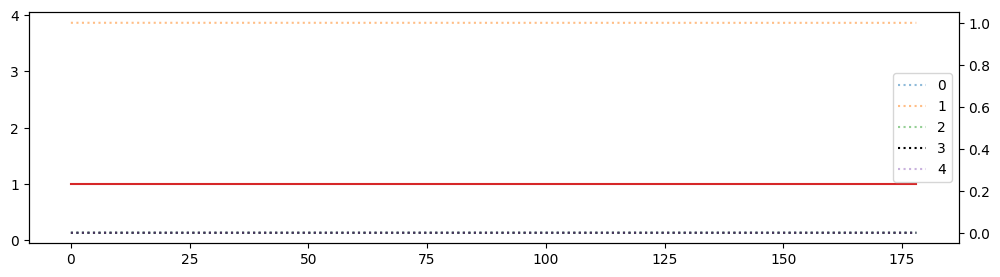

4


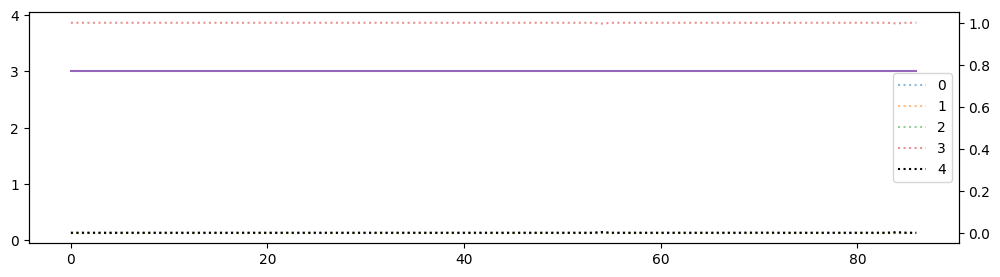

In [51]:
label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_all:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_preds += sample.T[1].tolist()
    label_gts += sample.T[2].tolist()
    label_confs += sample.T[3:8].T.tolist()
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    for l in range(config.n_clusters):
        if l != label_gt:
            ax1.plot(
                label_confs[mask][:, l], c=cm(l), alpha=0.5, linestyle=":", label=l
            )
        else:
            ax1.plot(label_confs[mask][:, l], c="black", linestyle=":", label=l)
    ax1.set_ylim(-0.05, 1.05)

    plt.legend()
    plt.show()

0


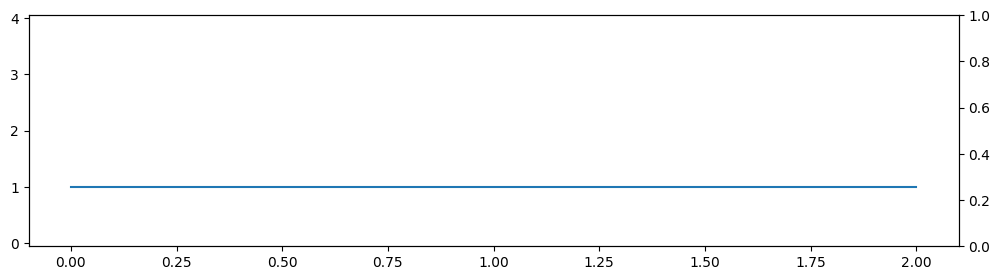

2


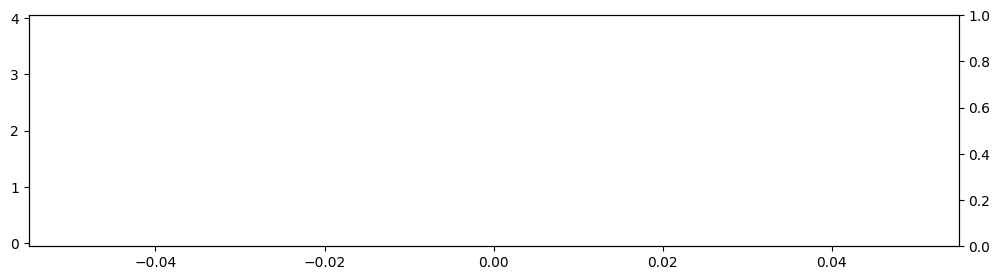

3


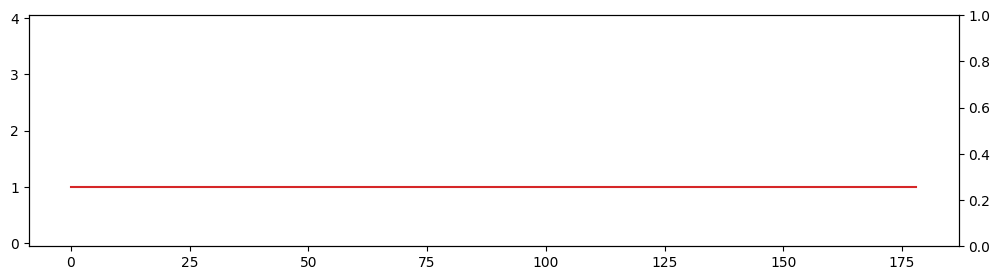

4


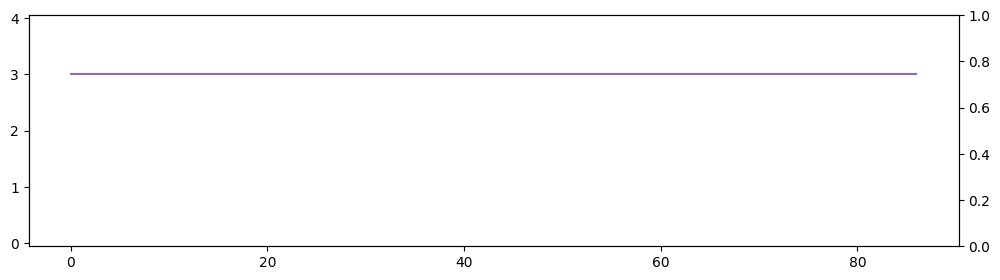

In [52]:
def correction(label_preds, label_confs, length=10):
    que_confs = []
    results = []
    for label, conf in zip(label_preds, label_confs):
        que_confs.append(conf)

        confs_tmp = np.array(que_confs)
        # weights = (np.arange(len(que_confs)) + 1) * 1 / length
        # confs_tmp = confs_tmp * weights.reshape(-1, 1)
        confs_tmp = np.mean(confs_tmp, axis=0)
        label = np.argmax(confs_tmp)
        results.append(label)

        if len(que_confs) == length:
            que_confs = que_confs[1:]
    return results


label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_all:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_gts += sample.T[2].tolist()
    label_preds_tmp = sample.T[1].tolist()
    label_confs_tmp = sample.T[3:8].T.tolist()
    label_preds_tmp = correction(label_preds_tmp, label_confs_tmp)
    label_preds += label_preds_tmp
    label_confs += label_confs_tmp
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    # max_conf = np.max(label_confs, axis=1)
    # ax1.plot(label_confs[mask][:1000, label_gt], c="black", alpha=0.5, linestyle=":")
    # ax1.plot(max_conf[mask][:1000], c="blue", alpha=0.5, linestyle=":")
    # ax1.set_ylim(-0.05, 1.05)

    plt.show()

# 一部に間違いがあるデータ

0


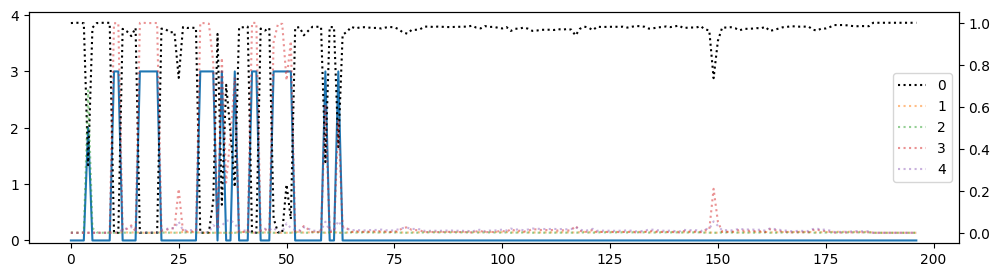

1


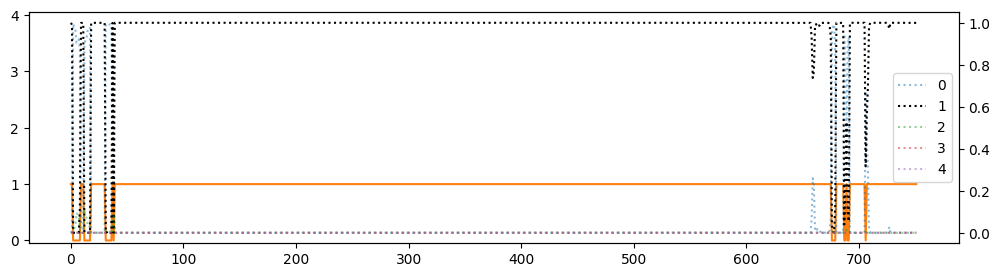

2


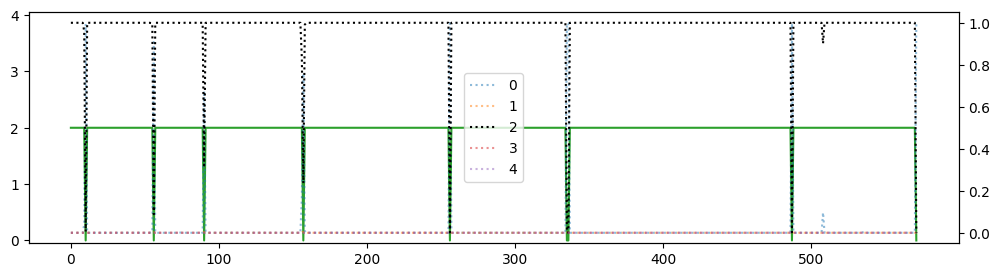

3


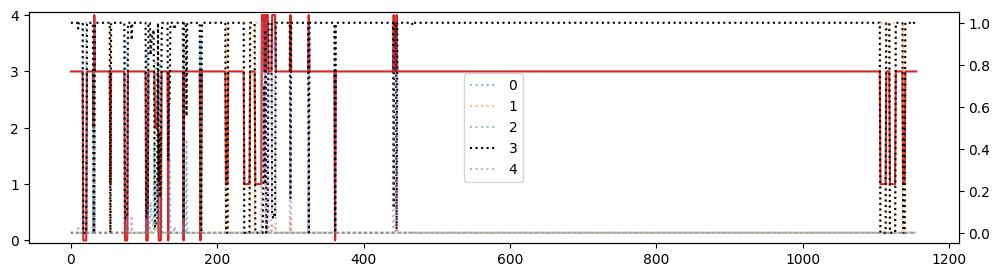

4


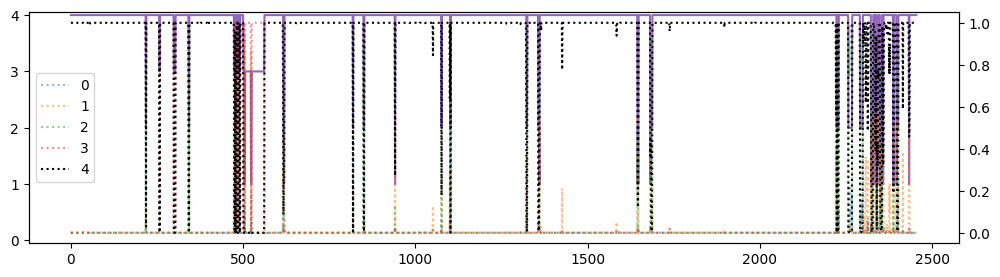

In [53]:
label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_part:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_preds += sample.T[1].tolist()
    label_gts += sample.T[2].tolist()
    label_confs += sample.T[3:8].T.tolist()
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    for l in range(config.n_clusters):
        if l != label_gt:
            ax1.plot(
                label_confs[mask][:, l], c=cm(l), alpha=0.5, linestyle=":", label=l
            )
        else:
            ax1.plot(label_confs[mask][:, l], c="black", linestyle=":", label=l)
    ax1.set_ylim(-0.05, 1.05)

    plt.legend()
    plt.show()

0


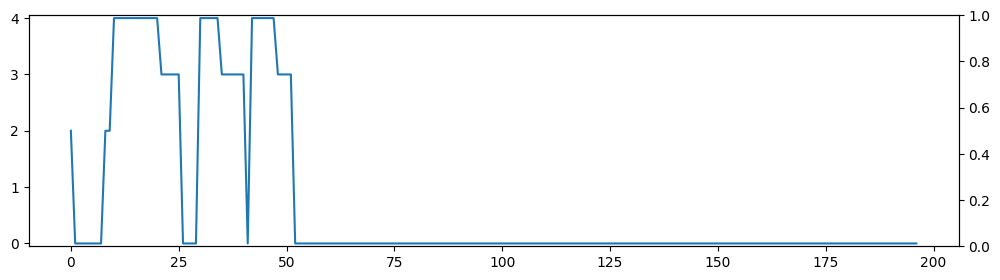

1


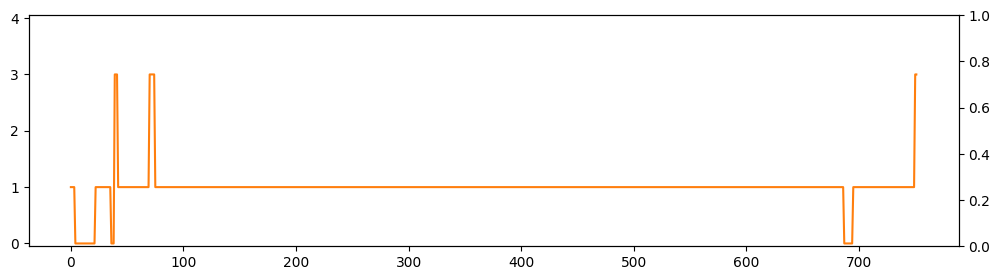

2


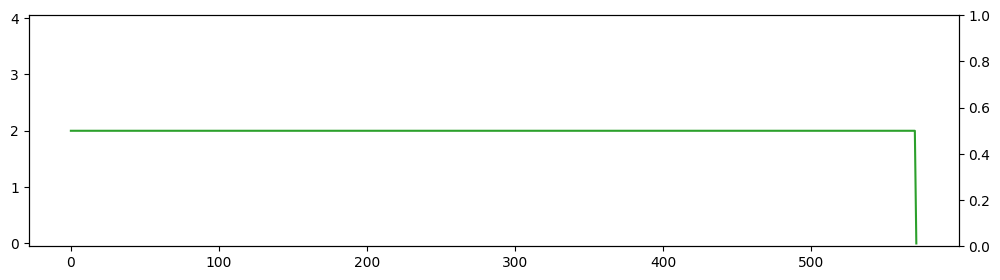

3


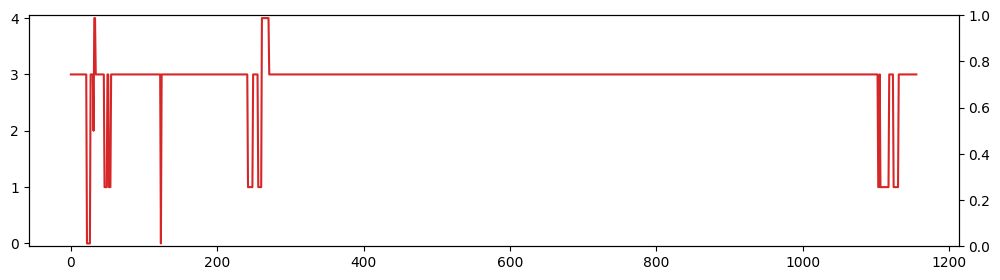

4


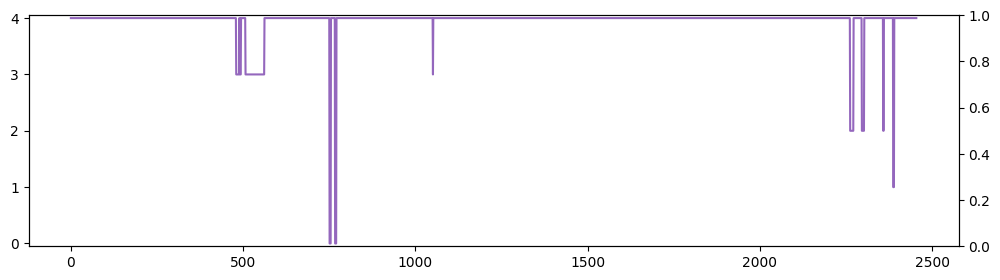

In [54]:
def correction(label_preds, label_confs, length=10):
    que_confs = []
    results = []
    for label, conf in zip(label_preds, label_confs):
        que_confs.append(conf)

        confs_tmp = np.array(que_confs)
        # weights = (np.arange(len(que_confs)) + 1) * 1 / length
        # confs_tmp = confs_tmp * weights.reshape(-1, 1)
        confs_tmp = np.mean(confs_tmp, axis=0)
        label = np.argmax(confs_tmp)
        results.append(label)

        if len(que_confs) == length:
            que_confs = que_confs[1:]
    return results


label_preds = []
label_gts = []
label_confs = []
for _id in miss_ids_part:
    sample = miss_samples[_id]
    sample = np.array(sample)
    label_gts += sample.T[2].tolist()
    label_preds_tmp = sample.T[1].tolist()
    label_confs_tmp = sample.T[3:8].T.tolist()
    label_preds_tmp = correction(label_preds_tmp, label_confs_tmp)
    label_preds += label_preds_tmp
    label_confs += label_confs_tmp
label_preds = np.array(label_preds).astype(int)
label_gts = np.array(label_gts).astype(int)
label_confs = np.array(label_confs)

cm = plt.get_cmap("tab10")
for label_gt in np.unique(label_gts):
    print(label_gt)
    fig = plt.figure(figsize=(12, 3))
    ax = fig.subplots()
    ax1 = ax.twinx()
    mask = label_gts == label_gt
    preds_tmp = label_preds[mask]

    # plot label
    c = cm(label_gt)
    ax.plot(label_preds[mask], c=c, label=label_gt)
    ax.set_ylim(-0.05, 4.05)

    # plot conf
    # max_conf = np.max(label_confs, axis=1)
    # ax1.plot(label_confs[mask][:1000, label_gt], c="black", alpha=0.5, linestyle=":")
    # ax1.plot(max_conf[mask][:1000], c="blue", alpha=0.5, linestyle=":")
    # ax1.set_ylim(-0.05, 1.05)

    plt.show()

In [55]:
result_ids = {}
ann_keys = annotations.T[0]
for result in results:
    key = result["key"]
    video_num, n_frame, _id = key.split("_")
    n_frame = int(n_frame)
    _id = int(_id)
    key = f"{video_num}_{_id}"
    label_pred = result["label"]
    label_conf = result["label_prob"]

    ann_tmp = annotations[ann_keys == key]
    if len(ann_tmp) >= 2:
        # groud truth is chenged sometimes since the tracking model mistakes
        ann_n_frames = ann_tmp.T[2].astype(int)
        ann_tmp = ann_tmp[ann_n_frames <= n_frame][-1]
        label_gt = int(ann_tmp[1])
    else:
        label_gt = int(ann_tmp[0, 1])

    if _id not in result_ids:
        result_ids[_id] = dict(label_preds=[], label_gts=[], label_confs=[])
    result_ids[_id]["label_preds"].append(label_pred)
    result_ids[_id]["label_gts"].append(label_gt)
    result_ids[_id]["label_confs"].append(label_conf)

In [56]:
for _id, items in result_ids.items():
    label_preds = items["label_preds"]
    label_confs = items["label_confs"]
    label_preds = correction(label_preds, label_confs, length=10)
    result_ids[_id]["label_preds"] = label_preds

0.9508979747802828


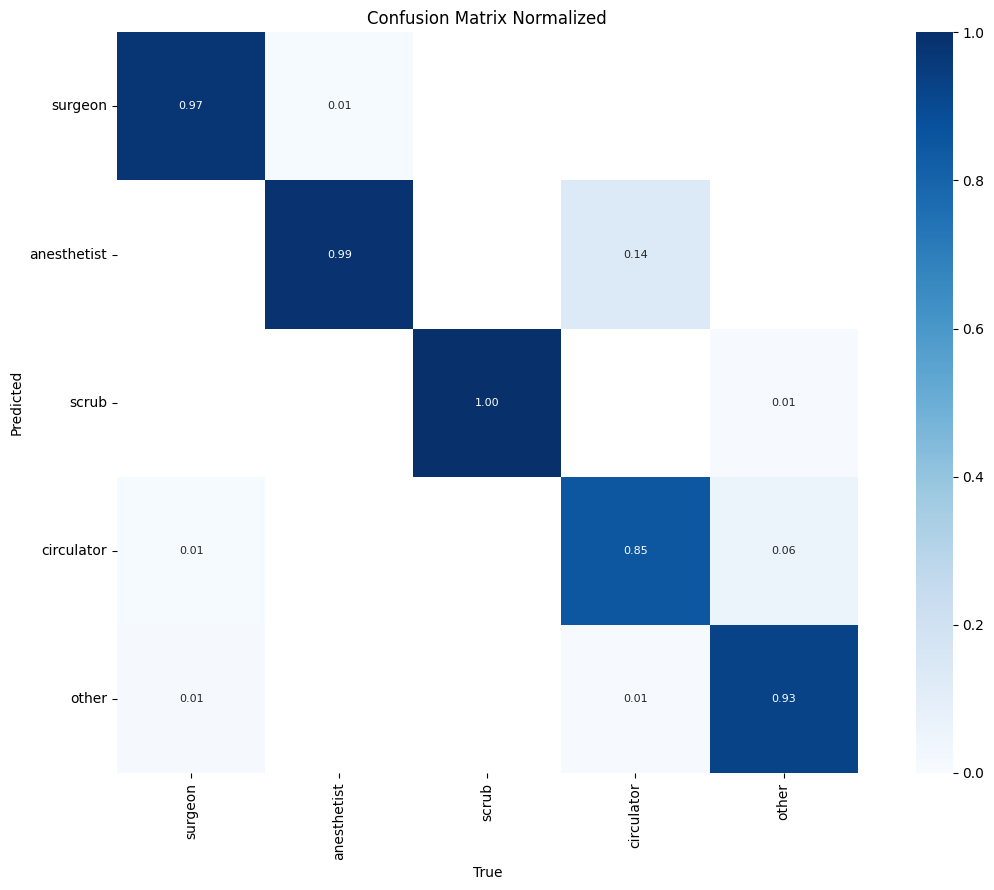

In [57]:
label_preds = []
label_gts = []
for items in result_ids.values():
    label_preds += items["label_preds"]
    label_gts += items["label_gts"]

print(accuracy_score(label_gts, label_preds))
cm = confusion_matrix(label_gts, label_preds).T
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
labels = np.loadtxt(path, str, usecols=0)
plot_cm(cm, labels, normalize=True)